<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/Prompt_engineering/Mistral7_b_prompt_Engineering_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.1 --progress-bar off
!pip install -qqq transformers==4.34.0 --progress-bar off
!pip install -qqq accelerate==0.23.0 --progress-bar off
!pip install -qqq bitsandbytes==0.41.1 --progress-bar off


In [2]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
    TextStreamer,
    pipeline,
)

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, device_map="auto", torch_dtype=torch.float16, load_in_8bit=True
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 2048
generation_config.temperature = 0.8
generation_config.do_sample = True


In [4]:

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)


In [5]:

llm = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=True,
    generation_config=generation_config,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    streamer=streamer,
)

# Zero-Shot Prompting
Large LLMs today, such as GPT-3, are tuned to follow instructions and are trained on large amounts of data; so they are capable of performing some tasks "zero-shot."

In [6]:

text = """[INST] Classify the text into neutral, negative or positive.
Text: I think the vacation is okay.
Sentiment:?  [/INST]"""

In [7]:
%%time
result = llm(text)

Based on my analysis, the sentiment of the text "I think the vacation is okay" is neutral.
CPU times: user 7.89 s, sys: 129 ms, total: 8.02 s
Wall time: 9.03 s


# Few-Shot Prompting
While large-language models demonstrate remarkable zero-shot capabilities, they still fall short on more complex tasks when using the zero-shot setting. Few-shot prompting can be used as a technique to enable in-context learning where we provide demonstrations in the prompt to steer the model to better performance. The demonstrations serve as conditioning for subsequent examples where we would like the model to generate a response.

In [8]:

text = """[INST] A "whatpu" is a small, furry animal native to Tanzania. An example of a sentence that uses the word whatpu is:
We were traveling in Africa and we saw these very cute whatpus.

To do a "farduddle" means to jump up and down really fast. An example of a sentence that uses the word farduddle is:? [/INST]"""

In [9]:
%%time
result = llm(text)

I'm sorry for the confusion, but I couldn't find any information on "farduddle" being a word or phrase used in any language. Could you please provide more context or clarification?
CPU times: user 12.5 s, sys: 0 ns, total: 12.5 s
Wall time: 12.5 s


# Chain-of-Thought Prompting

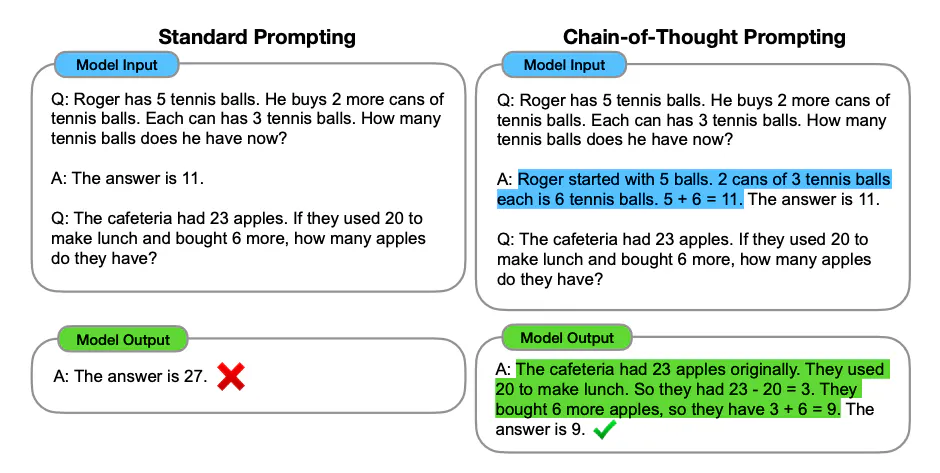

Introduced in Wei et al. (2022), chain-of-thought (CoT) prompting enables complex reasoning capabilities through intermediate reasoning steps. You can combine it with few-shot prompting to get better results on more complex tasks that require reasoning before responding.

In [10]:
text = """[INST]
Question: The odd numbers in this group add up to an even number: 4, 8, 9, 15, 12, 2, 1.
Answer: Adding all the odd numbers (9, 15, 1) gives 25. The answer is False.

Question: The odd numbers in this group add up to an even number: 17,  10, 19, 4, 8, 12, 24.
Answer: Adding all the odd numbers (17, 19) gives 36. The answer is True.

Question: The odd numbers in this group add up to an even number: 16,  11, 14, 4, 8, 13, 24.
Answer: Adding all the odd numbers (11, 13) gives 24. The answer is True.

Question: The odd numbers in this group add up to an even number: 17,  9, 10, 12, 13, 4, 2.
Answer: Adding all the odd numbers (17, 9, 13) gives 39. The answer is False.

Question:  The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1.
Answer:?
 [/INST]"""

In [11]:
%%time
result = llm(text)

The odd numbers in this group add up to an even number: 15, 32, 5, 13, 82, 7, 1.
Answer: Adding all the odd numbers (32, 13, 5, 7) gives 57. The answer is False.
CPU times: user 20.2 s, sys: 0 ns, total: 20.2 s
Wall time: 20.1 s


# Zero-shot COT Prompting --> chain of thought

# https://arxiv.org/pdf/2205.11916.pdf

One recent idea that came out more recently is the idea of zero-shot CoT (Kojima et al. 2022) that essentially involves adding "Let's think step by step" to the original prompt. Let's try a simple problem and see how the model performs:

In [12]:
text = """[INST]
Question: I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman. I then went and bought 5 more apples and ate 1.
Answer: How many apples did I remain with?
Let's think step by step.
 [/INST]"""

In [13]:
%%time
result = llm(text)

Sure, let's think through this step by step:

1. You initially bought 10 apples, but gave away 4 (2 to the neighbor and 2 to the repairman).
2. This leaves you with 10 - 4 = 6 apples.
3. Then, you bought 5 more apples, bringing your total to 11 apples.
4. However, you ate one apple, leaving you with 11 - 1 = 10 apples.

So, you remained with 10 apples.
CPU times: user 34.2 s, sys: 0 ns, total: 34.2 s
Wall time: 34.1 s


# Self-Consistency

Perhaps one of the more advanced techniques out there for prompt engineering is self-consistency. Proposed by Wang et al. (2022), self-consistency aims "to replace the naive greedy decoding used in chain-of-thought prompting". The idea is to sample multiple, diverse reasoning paths through few-shot CoT, and use the generations to select the most consistent answer. This helps to boost the performance of CoT prompting on tasks involving arithmetic and commonsense reasoning.

In [14]:
text = """[INST]
Question: There are 15 trees in the grove. Grove workers will plant trees in the grove today. After they are done,
there will be 21 trees. How many trees did the grove workers plant today?
Answer: We start with 15 trees. Later we have 21 trees. The difference must be the number of trees they planted.
So, they must have planted 21 - 15 = 6 trees. The answer is 6.

Question: If there are 3 cars in the parking lot and 2 more cars arrive, how many cars are in the parking lot?
Answer: There are 3 cars in the parking lot already. 2 more arrive. Now there are 3 + 2 = 5 cars. The answer is 5.

Question: Leah had 32 chocolates and her sister had 42. If they ate 35, how many pieces do they have left in total?
Answer: Leah had 32 chocolates and Leah’s sister had 42. That means there were originally 32 + 42 = 74
chocolates. 35 have been eaten. So in total they still have 74 - 35 = 39 chocolates. The answer is 39.

Question: Jason had 20 lollipops. He gave Denny some lollipops. Now Jason has 12 lollipops. How many lollipops
did Jason give to Denny?
Answer: Jason had 20 lollipops. Since he only has 12 now, he must have given the rest to Denny. The number of
lollipops he has given to Denny must have been 20 - 12 = 8 lollipops. The answer is 8.

Question: Shawn has five toys. For Christmas, he got two toys each from his mom and dad. How many toys does
he have now?
Answer: He has 5 toys. He got 2 from mom, so after that he has 5 + 2 = 7 toys. Then he got 2 more from dad, so
in total he has 7 + 2 = 9 toys. The answer is 9.

Question: There were nine computers in the server room. Five more computers were installed each day, from
monday to thursday. How many computers are now in the server room?
Answer: There are 4 days from monday to thursday. 5 computers were added each day. That means in total 4 * 5 =
20 computers were added. There were 9 computers in the beginning, so now there are 9 + 20 = 29 computers.
The answer is 29.

Question: Michael had 58 golf balls. On tuesday, he lost 23 golf balls. On wednesday, he lost 2 more. How many
golf balls did he have at the end of wednesday?
Answer: Michael initially had 58 balls. He lost 23 on Tuesday, so after that he has 58 - 23 = 35 balls. On
Wednesday he lost 2 more so now he has 35 - 2 = 33 balls. The answer is 33.

Question: Olivia has $23. She bought five bagels for $3 each. How much money does she have left?
Answer: She bought 5 bagels for $3 each. This means she spent $15. She has $8 left.

Question: When I was 6 my sister was half my age. Now I’m 70 how old is my sister?
Answer: ?
 [/INST]"""

In [15]:
%%time
result = llm(text)

It appears that the second question involves a math problem that cannot be solved without knowing the person's current age. Therefore, the answer is not available.
CPU times: user 8.85 s, sys: 0 ns, total: 8.85 s
Wall time: 8.83 s


# Generated Knowledge Prompting

LLMs continue to be improved and one popular technique includes the ability to incorporate knowledge or information to help the model make more accurate predictions.

Using a similar idea, can the model also be used to generate knowledge before making a prediction? That's what is attempted in the paper by Liu et al. 2022 -- generate knowledge to be used as part of the prompt.

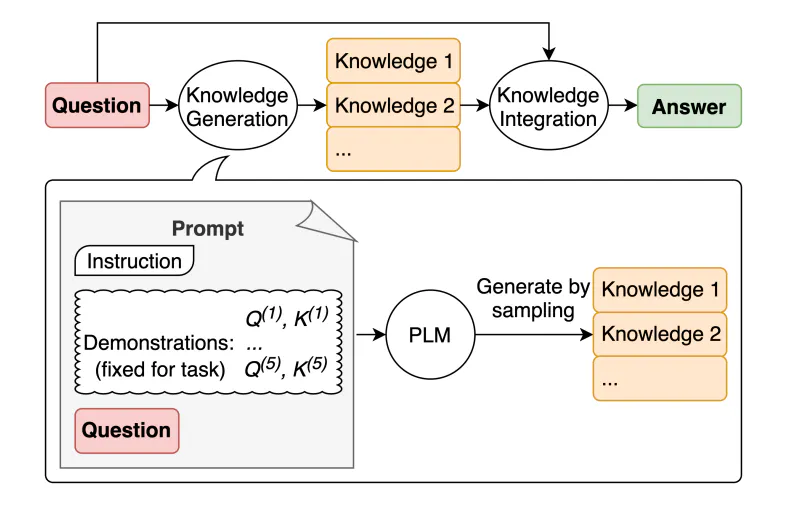

In [16]:
text = """[INST]
Input: Greece is larger than mexico.
Knowledge: Greece is approximately 131,957 sq km, while Mexico is approximately 1,964,375 sq km, making Mexico 1,389% larger than Greece.

Input: Glasses always fog up.
Knowledge: Condensation occurs on eyeglass lenses when water vapor from your sweat, breath, and ambient humidity lands on a cold surface, cools, and then changes into tiny drops of liquid, forming a film that you see as fog. Your lenses will be relatively cool compared to your breath, especially when the outside air is cold.

Input: A fish is capable of thinking.
Knowledge: Fish are more intelligent than they appear. In many areas, such as memory, their cognitive powers match or exceed those of ’higher’ vertebrates including non-human primates. Fish’s long-term memories help them keep track of complex social relationships.

Input: A common effect of smoking lots of cigarettes in one’s lifetime is a higher than normal chance of getting lung cancer.
Knowledge: Those who consistently averaged less than one cigarette per day over their lifetime had nine times the risk of dying from lung cancer than never smokers. Among people who smoked between one and 10 cigarettes per day, the risk of dying from lung cancer was nearly 12 times higher than that of never smokers.

Input: A rock is the same size as a pebble.
Knowledge: A pebble is a clast of rock with a particle size of 4 to 64 millimetres based on the Udden-Wentworth scale of sedimentology. Pebbles are generally considered larger than granules (2 to 4 millimetres diameter) and smaller than cobbles (64 to 256 millimetres diameter).

Input: Part of golf is trying to get a higher point total than others.
Knowledge:?
 [/INST]"""



In [17]:
%%time
result = llm(text)

Input: Part of golf is trying to get a higher point total than others.
Knowledge: Golf is a game played with clubs for hitting a small, white ball into a series of holes. The main objective of golf is to get the ball into the fewest number of strokes possible from the tee to the hole. Golf can be played individually or in teams, with the goal being to achieve the lowest possible score, which is the number of strokes taken to complete each hole.
CPU times: user 27.9 s, sys: 25.5 ms, total: 28 s
Wall time: 27.9 s


In [18]:
text = """[INST]
Question: Part of golf is trying to get a higher point total than others. Yes or No?

Knowledge: The objective of golf is to play a set of holes in the least number of strokes. A round of golf typically consists of 18 holes. Each hole is played once in the round on a standard golf course. Each stroke is counted as one point, and the total number of strokes is used to determine the winner of the game.

Explain and Answer:
 [/INST]"""



In [19]:
%%time
result = llm(text)

Yes, golf is played with the objective of getting a higher point total than others, but the method of achieving this is through strokes. The goal is to complete each hole in the least number of strokes possible, with the total number of strokes being used to determine the winner of the game.
CPU times: user 17 s, sys: 22.1 ms, total: 17 s
Wall time: 17 s


In [20]:
text = """[INST]
Question: Part of golf is trying to get a higher point total than others. Yes or No?

Knowledge: Golf is a precision club-and-ball sport in which competing players (or golfers) use many types of clubs to hit balls into a series of holes on a course using the fewest number of strokes. The goal is to complete the course with the lowest score, which is calculated by adding up the total number of strokes taken on each hole. The player with the lowest score wins the game.

Explain and Answer:
 [/INST]"""

In [21]:
%%time
result = llm(text)

Yes, part of golf is trying to get a higher point total than others. Golf is played against others, with the goal of completing the course with the lowest possible score. The player with the lowest score wins. So, in golf, players are trying to get a higher number of points or strokes than their opponents in order to win the game.
CPU times: user 19.6 s, sys: 33.4 ms, total: 19.6 s
Wall time: 19.5 s


# Prompt Chaining
To improve the reliability and performance of LLMs, one of the important prompting engineering techniques is to break tasks into its subtasks. Once those subtasks have been identified, the LLM is prompted with a subtask and then its response is used as input to another prompt. This is what's referred to as prompt chaining where a task is split into subtasks with the idea to create a chain of prompt operations.

Prompt chaining is useful to accomplish complex which an LLM might struggle to address if prompted with a very detailed prompt. In prompt chaining, chain prompts perform transformations or additional processes on the generated responses before reaching a final desired state.

Besides achieving better performance, prompt chaining helps to boost transparency of your LLM application, increases controllability, and reliability. This means that you can debug problems with model responses much easier and analyze and improve performance in the different stages that need improvement.

Prompt chaining is particularly useful when building LLM-powered conversational assistants and improving the personalization and user experience of your applications.

In [22]:

with open("/content/drive/MyDrive/data/llm_doc.txt", "r",encoding='windows-1252') as f:
  document = f.read()

In [23]:
len(document)

119397

In [24]:
text = f"""[INST]
You are a helpful assistant. Your task is to help answer a question given a document. The first step is to extract quotes relevant to the question from the document, delimited by ####. Please output the list of quotes using <quotes></quotes>. Respond with "No relevant quotes found!" if no relevant quotes were found.
####
{document[:5000]}
####
 [/INST]"""

In [25]:
text


'[INST] \nYou are a helpful assistant. Your task is to help answer a question given a document. The first step is to extract quotes relevant to the question from the document, delimited by ####. Please output the list of quotes using <quotes></quotes>. Respond with "No relevant quotes found!" if no relevant quotes were found.\n####\n\nLarge Language Models are Zero-Shot Reasoners\n\n\n\nTakeshi Kojima\nThe University of Tokyo\nt.kojima@weblab.t.u-tokyo.ac.jp\n\nShixiang Shane Gu\nGoogle Research, Brain Team\n\n\n\nMachel Reid\nGoogle Research?\n\nYutaka Matsuo\nThe University of Tokyo\n\nYusuke Iwasawa\nThe University of Tokyo\n\n\n\nAbstract\nPretrained large language models (LLMs) are widely used in many sub-fields of natural language processing (NLP) and generally known as excellent few-shot learners with task-specific exemplars. Notably, chain of thought (CoT) prompting, a recent technique for eliciting complex multi-step reasoning through step-by- step answer examples, achieved th

In [26]:
%%time
result = llm(text)

<quotes>
"Pretrained large language models (LLMs) are widely used in many sub-fields of natural language processing (NLP) and generally known as excellent few-shot learners with task-specific exemplars."
"While these successes are often attributed to LLMs’ ability for few-shot learning, we show that LLMs are decent zero-shot reasoners by simply adding “Let’s think step by step” before each answer."
"Experimental results demonstrate that our Zero-shot-CoT, using the same single prompt template, significantly outperforms zero-shot LLM performances on diverse benchmark reasoning tasks including arithmetics, symbolic reasoning, and other logical reasoning tasks, without any hand-crafted few-shot examples."
"The versatility of this single prompt across very diverse reasoning tasks hints at untapped and understudied fundamental zero-shot capabilities of LLMs, suggesting high-level, multi-task broad cognitive capabilities may be extracted by simple prompting."
"Our work not only serves as the

In [27]:
text = f"""[INST]
You are a helpful assistant. Your task is to help answer a question given a document. The first step is to extract quotes relevant to the question from the document, delimited by ####. Please output the list of quotes using <quotes></quotes>. Respond with "No relevant quotes found!" if no relevant quotes were found.
####
{document[:5000]}
<quotes>
Let’s think step by step.
Zero-shot-CoT outperforms zero-shot LLM performances on diverse benchmark reasoning tasks including arithmetics, symbolic reasoning, and other logical reasoning tasks.
Our Zero-shot-CoT using the same single prompt template significantly outperforms zero-shot LLM performances on diverse benchmark reasoning tasks.
The enormous zero-shot knowledge hidden inside LLMs hints at untapped and understudied fundamental zero-shot capabilities of LLMs.
</quotes>
####
 [/INST]"""

In [28]:
%%time
result = llm(text)

<quotes>
Let’s think step by step.
Zero-shot-CoT outperforms zero-shot LLM performances on diverse benchmark reasoning tasks including arithmetics, symbolic reasoning, and other logical reasoning tasks.
Our Zero-shot-CoT using the same single prompt template significantly outperforms zero-shot LLM performances on diverse benchmark reasoning tasks.
The enormous zero-shot knowledge hidden inside LLMs hints at untapped and understudied fundamental zero-shot capabilities of LLMs.
</quotes>
CPU times: user 32.1 s, sys: 77.2 ms, total: 32.1 s
Wall time: 32.1 s


# Tree of Thoughts (ToT)

For complex tasks that require exploration or strategic lookahead, traditional or simple prompting techniques fall short. Yao et el. (2023) and Long (2023) recently proposed Tree of Thoughts (ToT), a framework that generalizes over chain-of-thought prompting and encourages exploration over thoughts that serve as intermediate steps for general problem solving with language models.

ToT maintains a tree of thoughts, where thoughts represent coherent language sequences that serve as intermediate steps toward solving a problem. This approach enables an LM to self-evaluate the progress intermediate thoughts make towards solving a problem through a deliberate reasoning process. The LM's ability to generate and evaluate thoughts is then combined with search algorithms (e.g., breadth-first search and depth-first search) to enable systematic exploration of thoughts with lookahead and backtracking.

The ToT framework is illustrated below:

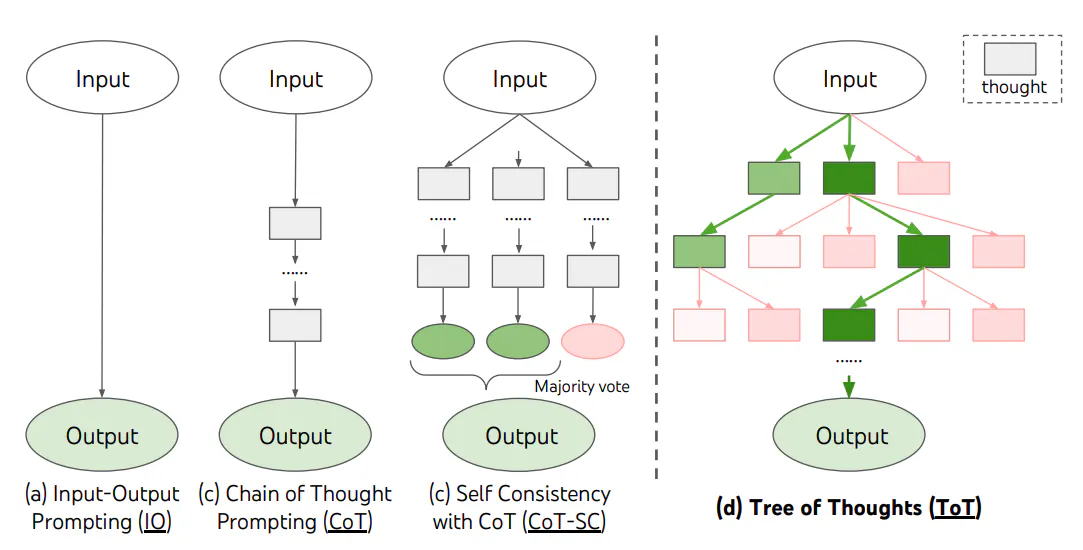

When using ToT, different tasks requires defining the number of candidates and the number of thoughts/steps. For instance, as demonstrated in the paper, Game of 24 is used as a mathematical reasoning task which requires decomposing the thoughts into 3 steps, each involving an intermediate equation. At each step, the best b=5 candidates are kept.

To perform BFS in ToT for the Game of 24 task, the LM is prompted to evaluate each thought candidate as "sure/maybe/impossible" with regard to reaching 24. As stated by the authors, "the aim is to promote correct partial solutions that can be verdicted within few lookahead trials, and eliminate impossible partial solutions based on "too big/small" commonsense, and keep the rest "maybe"". Values are sampled 3 times for each thought. The process is illustrated below:


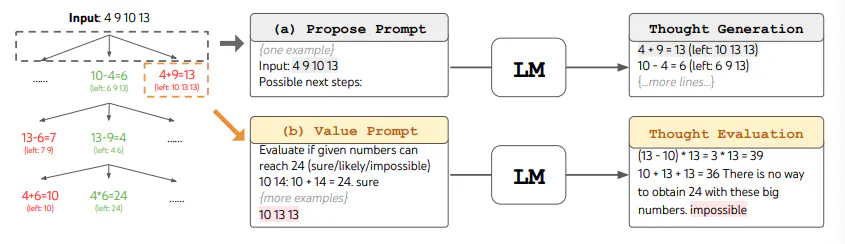

code

https://github.com/princeton-nlp/tree-of-thought-llm

https://github.com/jieyilong/tree-of-thought-puzzle-solver


# Retrieval Augmented Generation (RAG)
General-purpose language models can be fine-tuned to achieve several common tasks such as sentiment analysis and named entity recognition. These tasks generally don't require additional background knowledge.

For more complex and knowledge-intensive tasks, it's possible to build a language model-based system that accesses external knowledge sources to complete tasks. This enables more factual consistency, improves reliability of the generated responses, and helps to mitigate the problem of "hallucination".

Meta AI researchers introduced a method called Retrieval Augmented Generation (RAG) to address such knowledge-intensive tasks. RAG combines an information retrieval component with a text generator model. RAG can be fine-tuned and its internal knowledge can be modified in an efficient manner and without needing retraining of the entire model.

RAG takes an input and retrieves a set of relevant/supporting documents given a source (e.g., Wikipedia). The documents are concatenated as context with the original input prompt and fed to the text generator which produces the final output. This makes RAG adaptive for situations where facts could evolve over time. This is very useful as LLMs's parametric knowledge is static. RAG allows language models to bypass retraining, enabling access to the latest information for generating reliable outputs via retrieval-based generation.

Lewis et al., (2021) proposed a general-purpose fine-tuning recipe for RAG. A pre-trained seq2seq model is used as the parametric memory and a dense vector index of Wikipedia is used as non-parametric memory (accessed using a neural pre-trained retriever). Below is a overview of how the approach works:

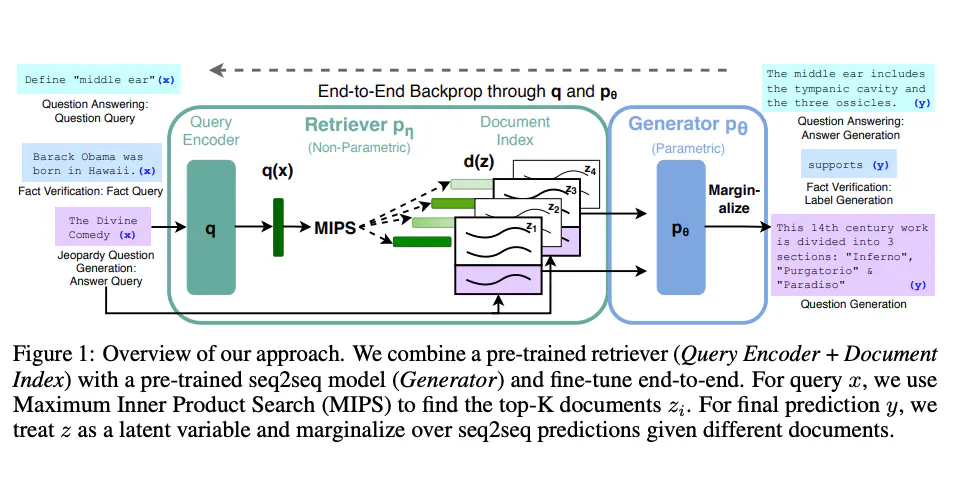

# Hallucinations

https://www.iguazio.com/glossary/llm-hallucination/

LLM hallucinations are the events in which ML models, particularly large language models (LLMs) like GPT-3 or GPT-4, produce outputs that are coherent and grammatically correct but factually incorrect or nonsensical. “Hallucinations” in this context means the generation of false or misleading information. These hallucinations can occur due to various factors, such as limitations in training data, biases in the model, or the inherent complexity of language.

In the example below you can see an amusing, albeit mostly harmless, example. However, LLM hallucinations are particularly concerning in fields that require high levels of accuracy and have a significant impact on people’s lives, like healthcare, law, or engineering.

Therefore, it’s essential to cross-reference the information provided by LLMs.

An LLM hallucination in action:

In [29]:
text = f"""[INST]
How many 'm's are in the word 'Weather'?
 [/INST]"""

In [30]:
%%time
result = llm(text)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


The word 'Weather' has two 'm's.
CPU times: user 3.98 s, sys: 17 ms, total: 4 s
Wall time: 4.01 s


In [32]:
text = f"""[INST]
quention: How many 'm's are in the word 'Weather'?
your previous answer: The word 'Weather' has two 'm's.
question: Are you sure?
answer:?
 [/INST]"""

In [33]:
%%time
result = llm(text)

No, I apologize for the mistake. The word 'Weather' actually has three 'm's.
CPU times: user 6.62 s, sys: 9.22 ms, total: 6.63 s
Wall time: 6.61 s


In [34]:
text = f"""[INST]
quention: How many 'm's are in the word 'Weather'?
your previous answer: The word 'Weather' has two 'm's.
question: Are you sure?
second answer:No, I apologize for the mistake. The word 'Weather' actually has three 'm's.
question: are you really sure?
 [/INST]"""

In [35]:
%%time
result = llm(text)

I apologize for the confusion, but my previous answer was correct. The word 'Weather' has three 'm's.
CPU times: user 7.71 s, sys: 18.6 ms, total: 7.73 s
Wall time: 7.71 s


# Automatic Reasoning and Tool-use (ART)

Combining CoT prompting and tools in an interleaved manner has shown to be a strong and robust approach to address many tasks with LLMs. These approaches typically require hand-crafting task-specific demonstrations and carefully scripted interleaving of model generations with tool use. Paranjape et al., (2023) propose a new framework that uses a frozen LLM to automatically generate intermediate reasoning steps as a program.

ART works as follows:

given a new task, it select demonstrations of multi-step reasoning and tool use from a task library
at test time, it pauses generation whenever external tools are called, and integrate their output before resuming generation
ART encourages the model to generalize from demonstrations to decompose a new task and use tools in appropriate places, in a zero-shot fashion. In addition, ART is extensible as it also enables humans to fix mistakes in the reasoning steps or add new tools by simply updating the task and tool libraries. The process is demonstrated below:

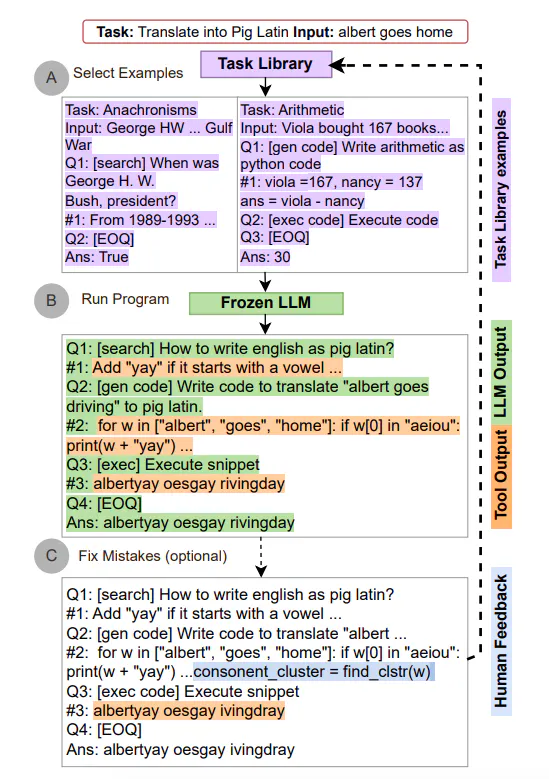

# Automatic Prompt Engineer (APE)

Zhou et al., (2022) propose automatic prompt engineer (APE) a framework for automatic instruction generation and selection. The instruction generation problem is framed as natural language synthesis addressed as a black-box optimization problem using LLMs to generate and search over candidate solutions.

The first step involves a large language model (as an inference model) that is given output demonstrations to generate instruction candidates for a task. These candidate solutions will guide the search procedure. The instructions are executed using a target model, and then the most appropriate instruction is selected based on computed evaluation scores.

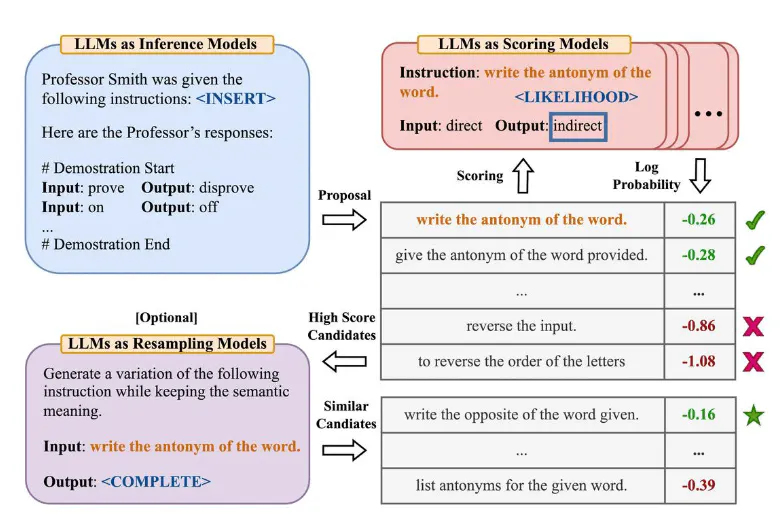

# Active-Prompt
Chain-of-thought (CoT) methods rely on a fixed set of human-annotated exemplars. The problem with this is that the exemplars might not be the most effective examples for the different tasks. To address this, Diao et al., (2023) recently proposed a new prompting approach called Active-Prompt to adapt LLMs to different task-specific example prompts (annotated with human-designed CoT reasoning).

Below is an illustration of the approach. The first step is to query the LLM with or without a few CoT examples. k possible answers are generated for a set of training questions. An uncertainty metric is calculated based on the k answers (disagreement used). The most uncertain questions are selected for annotation by humans. The new annotated exemplars are then used to infer each question.

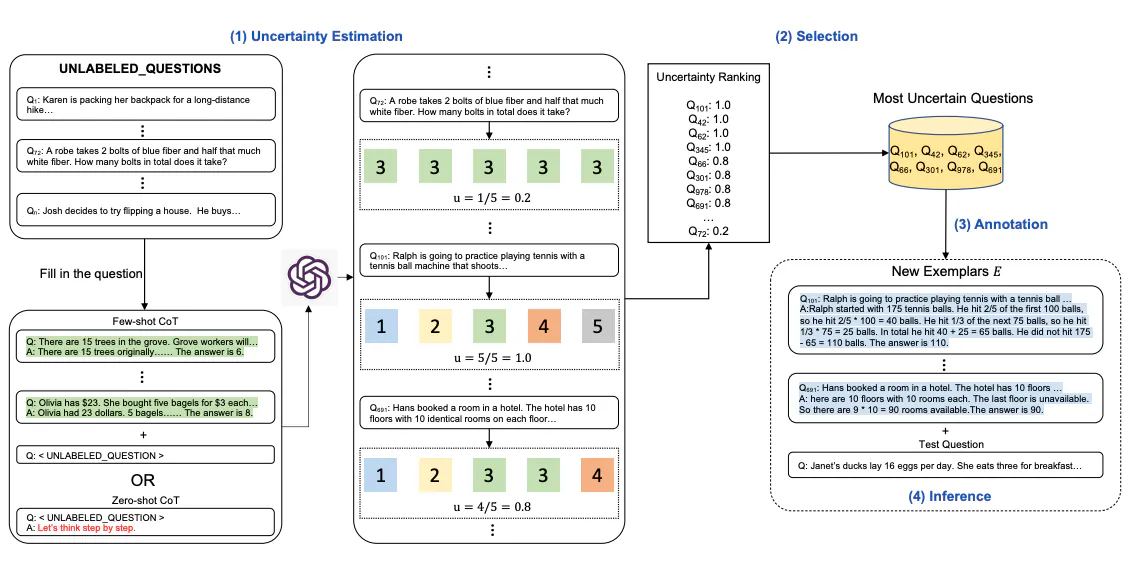

# Directional Stimulus Prompting

Li et al., (2023) proposes a new prompting technique to better guide the LLM in generating the desired summary.

A tuneable policy LM is trained to generate the stimulus/hint. Seeing more use of RL to optimize LLMs.

The figure below shows how Directional Stimulus Prompting compares with standard prompting. The policy LM can be small and optimized to generate the hints that guide a black-box frozen LLM.


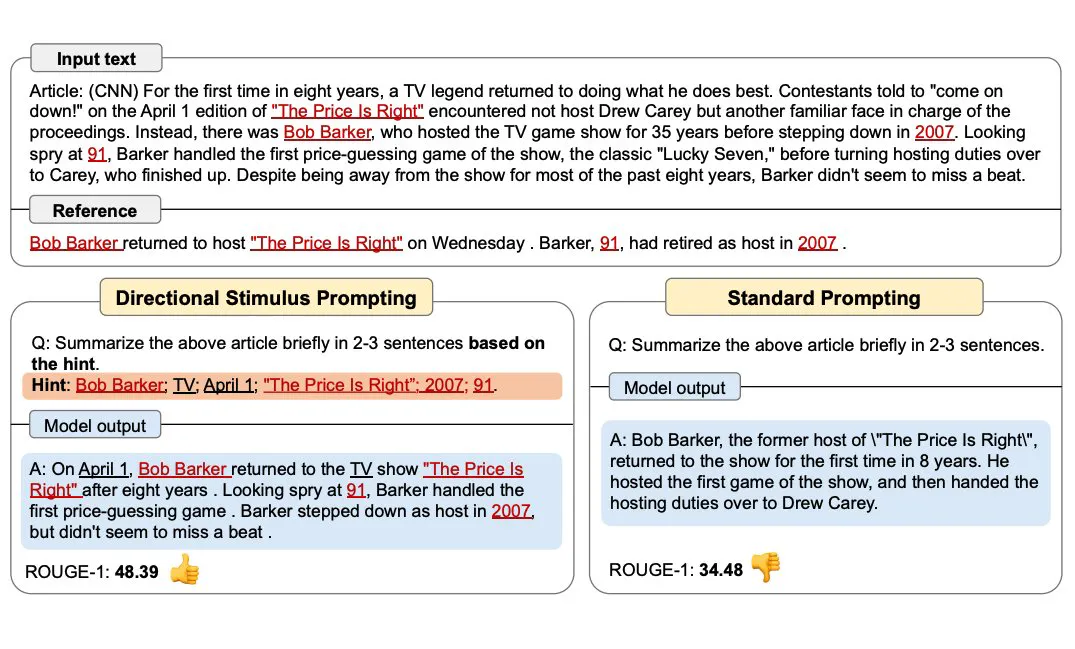


# PAL (Program-Aided Language Models)

Gao et al., (2022) presents a method that uses LLMs to read natural language problems and generate programs as the intermediate reasoning steps. Coined, program-aided language models (PAL), it differs from chain-of-thought prompting in that instead of using free-form text to obtain solution it offloads the solution step to a programmatic runtime such as a Python interpreter.

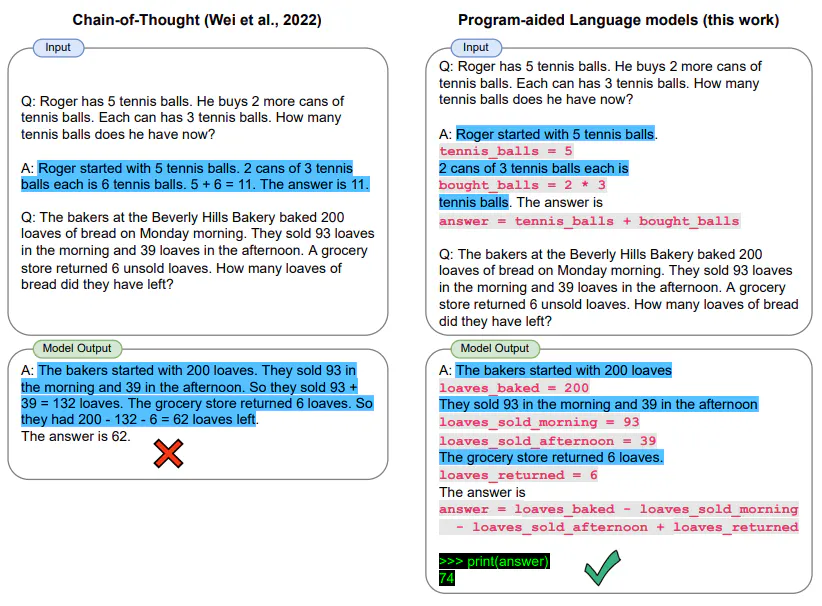


Other Prompting Techniques

- ReAct Prompting https://www.promptingguide.ai/techniques/react
- Multimodal CoT Prompting https://www.promptingguide.ai/techniques/multimodalcot
- GraphPrompts https://www.promptingguide.ai/techniques/graph